# Logistic Regression Analysis Experiment




In [2]:
!pip install ucimlrepo


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from tqdm import tqdm
import numpy as np
import sklearn as sk
import pandas as pd
import sklearn.model_selection
import matplotlib.pyplot as plt
import random
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# utils
def normalize_features(df, method='z-score'):
    # Extract the feature columns (excluding 'MEDV')
    feature_cols = [col for col in df.columns if col != 'MEDV']

    if method == 'z-score':
        # Z-score normalization
        means = df[feature_cols].mean()
        std_devs = df[feature_cols].std()

        # Apply z-score normalization to the feature columns
        normalized_df = df.copy()
        normalized_df[feature_cols] = (df[feature_cols] - means) / std_devs
    elif method == 'min-max':
        # Min-max scaling
        min_val = df[feature_cols].min()
        max_val = df[feature_cols].max()

        # Apply Min-max scaling normalization to the feature columns
        normalized_df = df.copy()
        normalized_df[feature_cols] = (df[feature_cols] - min_val) / (max_val - min_val)
    else:
        raise ValueError("Invalid normalization method.")

    return normalized_df

def draw_loss(L_vals):
    plt.plot(list(range(len(L_vals))), L_vals, '-o', color='blue')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Iterations VS Loss')
    plt.show()

def softmax(u):
    # return np.exp(u) / np.sum(np.exp(u))
    # use log_softmax instead to prevent overflow
    return np.exp(u - np.max(u) - np.log(np.sum(np.exp(u - np.max(u)))))

def cross_entropy(p, q, eps=1e-10):
    q = np.clip(q, eps, 1 - eps)
    return -p @ np.log(q)


def Xhat(X):
    if len(X.shape) == 1:
        return np.insert(X, 0, 1)
    return np.column_stack((np.ones((X.shape[0], 1)),X))

def grad_L_m(X, y, beta):
    if len(X.shape) == 1:
        return np.outer(Xhat(X), (softmax(Xhat(X) @ beta) - y))
    return (np.transpose(Xhat(X)) @ (softmax(Xhat(X) @ beta) - y)) / X.shape[0]

def eval_L_m(X, y, beta):
    return np.average([cross_entropy(y[index], softmax(xi @ beta)) for index, xi in enumerate(Xhat(X))])

def train_model_using_grad_descent_multi(X, y, alpha, max_iter):
    beta = np.zeros((X.shape[1] + 1, y.shape[1])).astype("float64")
    L_vals = []
    for _ in tqdm(range(max_iter)):
        beta = beta - alpha * grad_L_m(X, y, beta)
        L_vals.append(eval_L_m(X, y, beta))
    return beta, L_vals

def MSE(Yhat, Y):
    n = Yhat.shape[0]
    res = (Yhat - Y) ** 2

    return sum(res)/n

def zerohot(df, axis = 0):
    # input: array or dataframe that is one-hot encoded or simply categorical, the axis along which we decode (default = 0)
    # returns: the argmax value of the one-hot encoded columns/axes
    unhot = np.argmax(df, axis)
    return unhot

def cMatrix_log(Yhat, Y, axis = (0,1), onehot = False):
    # logistic regression confusion matrix
    # Inputs Yhat: predicted values, Y: expected values. Yhat and Y can be either lists, np.arrays.
    # Axis tuple to precise along which axis of the matrix we decode for Yhat, Y respectively
    # returns df of confusion matrix

    if ~onehot:
        d = {'Predicted Values': Yhat, 'Actual Values': Y}
        df = pd.DataFrame(data = d)

        cMat = pd.crosstab(df["Predicted Values"], df['Actual Values'])
        fig, ax = plt.subplots(1, 1, figsize = (10,5))
        ax.set_title('Confusion Matrix for Logistic Regression')
        sns.heatmap(cMat, annot = True)

    else:
        d = {'Predicted Values': zerohot(Yhat, axis[0]), 'Actual Values': zerohot(Y, axis[1])}
        df = pd.DataFrame(data = d)

        cMat = pd.crosstab(df["Predicted Values"], df['Actual Values'])
        fig, ax = plt.subplots(1, 1, figsize = (10,5))
        ax.set_title('Confusion Matrix for Logistic Regression')
        sns.heatmap(cMat, annot = True)

    # The code that follows will only run after all plots got drawed
    plt.show()
    return cMat

def ComputeMetrics(cMat):
    for idx in range(cMat.shape[0]):
        TP = np.sum(cMat.iloc[idx,idx])
        FP = np.sum(cMat.iloc[idx,:]) - TP
        FN = np.sum(cMat.iloc[:,idx]) - TP
        TN = np.sum(cMat.sum()) - TP - FP - FN

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F1 = 2 * precision * recall / (precision + recall)

        print("Category: %d, Metrics for accuracy: %f, precision: %f, recall: %f, F1: %f" % (idx, accuracy, precision, recall, F1))

def metricsWrapper(y_train_hat, y_train, y_test_hat, y_test):
    print("Overall Accuracy for training set: ", str(np.average(y_train_hat == y_train)))
    print("Performance metrics for training set: ")
    ComputeMetrics(cMatrix_log(y_train_hat, y_train, onehot = False, axis = (0,0)))

    print("==========================")
    print("Overall Accuracy for test set: ", str(np.average(y_test_hat == y_test)))
    print("Performance metrics for test set:")
    ComputeMetrics(cMatrix_log(y_test_hat, y_test, onehot = False, axis = (0,0)))


## Task 1: Acquire, preprocess, and analyze the data

### I. Data cleaning and pre-processing

In [5]:
# Fetch dataset
wine = fetch_ucirepo(id=109)

# Create DataFrames for features (X) and classification class (y)
X = pd.DataFrame(data=wine.data.features)
y = pd.DataFrame(data=wine.data.targets)
wine_df = pd.concat([X, y], axis=1)

# Check missing value (NaN)
missing_values = wine_df.isnull().any().any()
# Check non-numeric values
malformed_values = wine_df.select_dtypes(exclude=['number']).any().any()
missing_values, malformed_values

(False, False)

### II. Exploratory Data Analysis

In [6]:
wine_df.head()

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


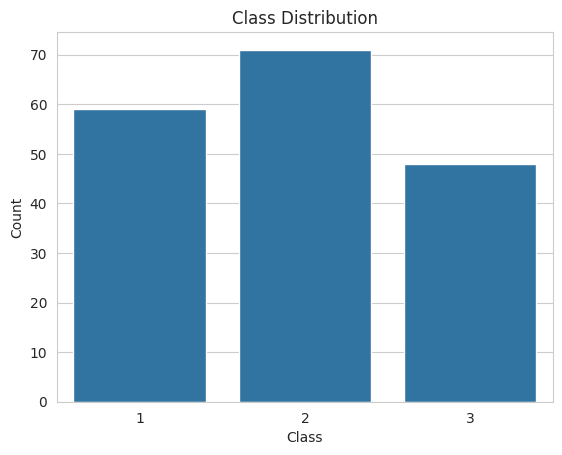

In [7]:
# Distributions of the different classes
ax = sns.countplot(data=wine_df, x='class')
ax.set(xlabel='Class', ylabel='Count', title='Class Distribution')
plt.show()

Distributions between classes are roughly even. There are slightly more class 2 wines and less class three wines.

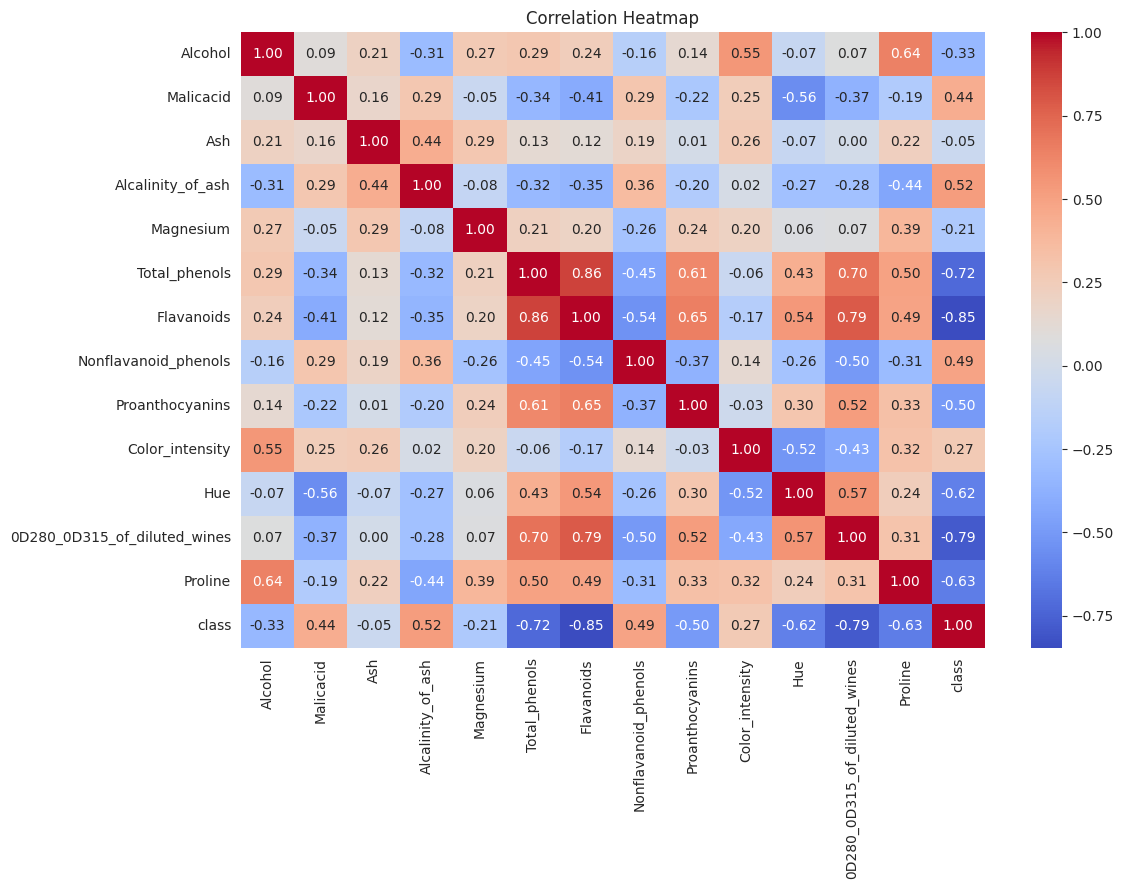

In [8]:
# correlation between features
correlation_matrix = wine_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Top 3 highest correlation with class: Flavanoids, diluted_wines, total_phenols which may indicates these three features are most important.

## Task 2: Implement the models

### 2.2 Logistic Regression with gradient descent

In [9]:
# Multiclass Gradient descent
class LogisticRegression:

    def __init__(self, alpha=0.01, max_iter=500):
        self.beta = None
        self.L_vals = None
        self.alpha = alpha
        self.max_iter = max_iter

    def fit(self, X_train, y_train):
        # one-hot-encoding y_train
        unique_classes, inverse = np.unique(y_train, return_inverse=True)
        y_train_hot = np.zeros((len(y_train), len(unique_classes)))
        y_train_hot[np.arange(len(y_train)), inverse] = 1

        self.beta, self.L_vals = train_model_using_grad_descent_multi(X_train, y_train_hot, self.alpha, self.max_iter)
        return self

    def predict(self, X_test):
        # first class in y_pred is class 2 in Y
        y_pred = [np.argmax(yi) + 1 for yi in (Xhat(X_test) @ self.beta)]
        return y_pred

### 2.3 Logistic Regression with mini-batch stochastic gradient descent

In [10]:
# TODO: Yuhao

## Task 3: Run experiemnts

### 3.1 Accuracy, precision, recall, and F1-score for each model (82split, metrics for training and test set)

#### 3.1.1 Gradient descent

100%|██████████| 300/300 [00:01<00:00, 186.80it/s]


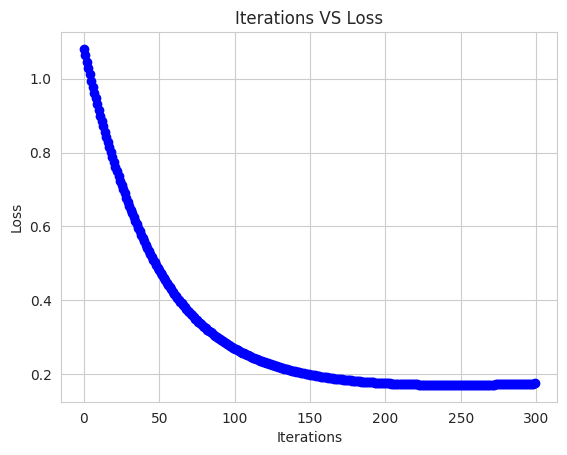

In [11]:
X = normalize_features(X)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(alpha=0.01, max_iter=300)
logReg = model.fit(X_train, y_train)

# Iteration VS Loss plot
draw_loss(logReg.L_vals)

# performance metrics
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

Overall Accuracy for training set:  0.9366197183098591
Performance metrics for training set: 


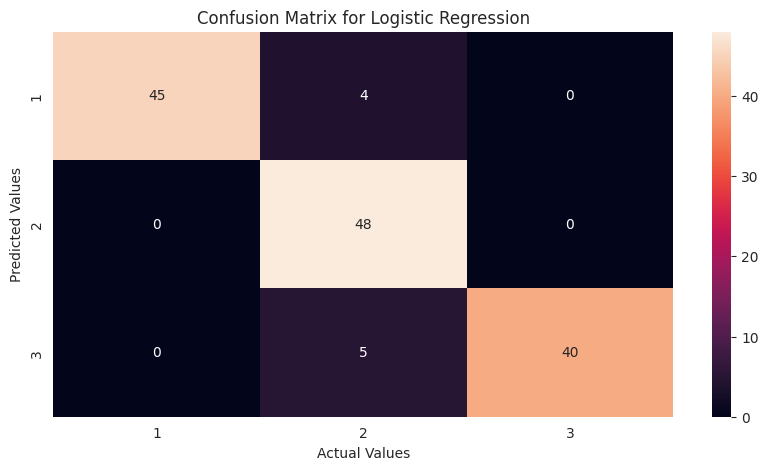

Category: 0, Metrics for accuracy: 0.971831, precision: 0.918367, recall: 1.000000, F1: 0.957447
Category: 1, Metrics for accuracy: 0.936620, precision: 1.000000, recall: 0.842105, F1: 0.914286
Category: 2, Metrics for accuracy: 0.964789, precision: 0.888889, recall: 1.000000, F1: 0.941176
Overall Accuracy for test set:  0.9722222222222222
Performance metrics for test set:


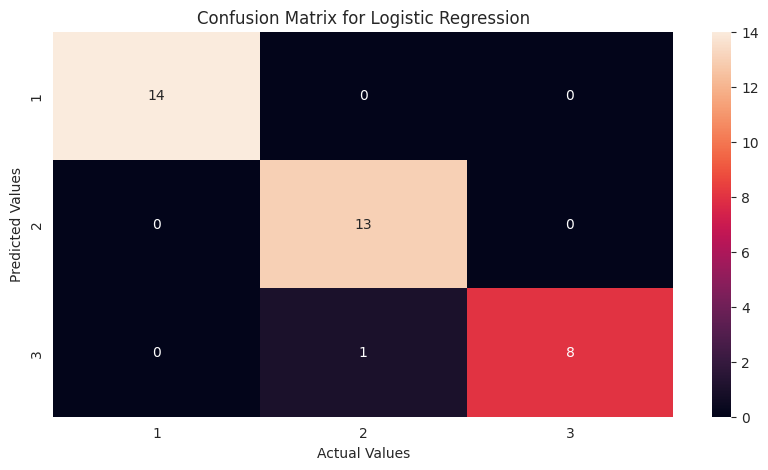

Category: 0, Metrics for accuracy: 1.000000, precision: 1.000000, recall: 1.000000, F1: 1.000000
Category: 1, Metrics for accuracy: 0.972222, precision: 1.000000, recall: 0.928571, F1: 0.962963
Category: 2, Metrics for accuracy: 0.972222, precision: 0.888889, recall: 1.000000, F1: 0.941176


In [12]:
metricsWrapper(y_train_hat, y_train['class'].values, y_test_hat, y_test['class'].values)

#### 3.1.2 Mini-batch stochastic gradient descent

In [ ]:
# TODO: Yuhao

### 3.2 5-fold CV for each model (metrics for training and test set)

#### 3.2.1 Gradient descent

In [24]:
# Split Dataframe to N folds
def split_dataframe(df, n_folds=5, random_seed=10):
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    fold_size = len(df_shuffled) // n_folds

    folds = []
    for i in range(n_folds):
        if i == n_folds - 1:
            # Store remaining data to last fold
            folds.append(df_shuffled.iloc[i*fold_size:])
        else:
            folds.append(df_shuffled.iloc[i*fold_size:(i+1)*fold_size])

    return folds

In [18]:
folds = split_dataframe(wine_df)

for idx, fold in enumerate(folds):
    data_train = pd.concat(folds[:idx] + folds[idx+1:])

#### 3.2.2 Mini-batch stochastic gradient descent

In [ ]:
# TODO: Yuhao

#### B1. Original Data vs Normalized Data training
- Assume the train size is 0.7
- We investigate three models (original data, z-score normalization, min-max normalization)

#### Conclusion
- We found that the performance without the normalization is the best

In [ ]:
# Extract features and Output
X = housing_df.drop(columns=['MEDV']).values
y = housing_df['MEDV'].values

In [ ]:
# Train the LR with original data
model = LinearRegressionModel()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = model.cal_mean_square_error(y_test, y_pred)

print(f"MSE for original data: {mse}")

MSE for original data: 21.115450613870692


In [ ]:
# Train the LR with Z-score normalization
X_train_normalized = pd.DataFrame(X_train).apply(z_score_normalize_column).values
model = LinearRegressionModel()
model.fit(X_train_normalized, y_train)

X_test = pd.DataFrame(X_test).apply(z_score_normalize_column).values
y_pred = model.predict(X_test)
mse_z_score = model.cal_mean_square_error(y_test, y_pred)

print(f"MSE by z-score normalization: {mse_z_score}")

MSE by z-score normalization: 23.996789251839218


In [ ]:
# Train the LR with the min-max normalization
X_train_normalized = pd.DataFrame(X_train).apply(min_max_normalize_column).values
model = LinearRegressionModel()
model.fit(X_train_normalized, y_train)

X_test = pd.DataFrame(X_test).apply(min_max_normalize_column).values
y_pred = model.predict(X_test)
mse_min_max = model.cal_mean_square_error(y_test, y_pred)

print(f"MSE by min-max normalization: {mse_min_max}")

MSE by min-max normalization: 22.1222698991828


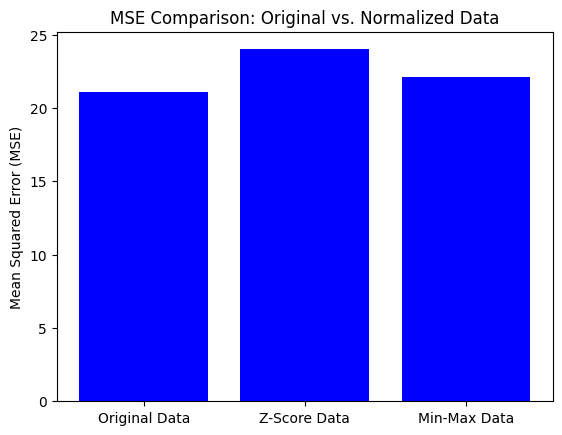

In [ ]:
# Plot a bar chart to compare MSE
labels = ['Original Data', 'Z-Score Data', 'Min-Max Data']
mse_values = [mse, mse_z_score, mse_min_max]

plt.bar(labels, mse_values, color='b')
plt.title('MSE Comparison: Original vs. Normalized Data')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

#### B2. Different Training Size
- Assume we are using the original data
- We will test on 0.5, 0.6, 0.7, and 0.8 training set size

#### Conclusion
- we can see the 0.7 training size is the best

In [ ]:
# Extract features and Output
X = housing_df.drop(columns=['MEDV']).values
y = housing_df['MEDV'].values

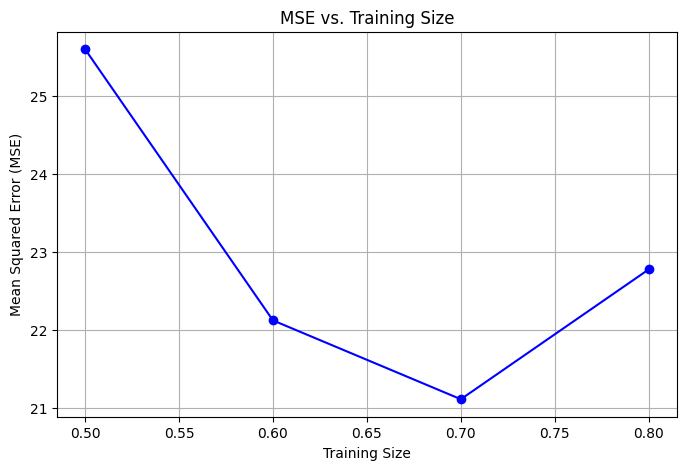

In [ ]:
# Experiment with different train sizes
train_sizes = [0.5, 0.6, 0.7, 0.8]
mse_scores = []

for train_size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)

    # Initialize and train your linear regression model
    model = LinearRegressionModel()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate and store the MSE
    mse = model.cal_mean_square_error(y_test, y_pred)
    mse_scores.append(mse)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, mse_scores, marker='o', linestyle='-', color='b')
plt.title('MSE vs. Training Size')
plt.xlabel('Training Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

#### B2. Difference between original testing and applying Gaussian Basis Functions
- Employ a total of 5 Gaussian basis functions.
- Set the spatial scale parameter, s, to a value of 1.
- Select μj values randomly from the training set to determine the centers of these basis functions. • Use analytical linear regression to predict the target value.


In [ ]:
# Extract features and Output
X = housing_df.drop(columns=['MEDV']).values
y = housing_df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Task 2.3: Train Linear Regression with Gradient Descent
- Implement linear regression models using both mini-batch stochastic gradient descent and normal gradient descent.
- Compare the differences between the analytical approach and gradient descent methods.

### A. Model Training



*   If we directly use the original data to train the model with gradient descent, the model will be overflowed
*   The problem is solved by the Normalization



### A1.1 Using Normal Gradient Descent

##### i. Some Helper Functions

In [ ]:
import random

In [ ]:
def cal_L2_gradient(X, Y, w):
      yh =  np.dot(X, w)
      return (X.T @ (yh - Y)) / X.shape[0]

def cal_mse(X, Y, w):
      yh = np.dot(X, w)
      res = (yh - Y)**2
      return sum(res) / X.shape[0]

def draw_loss(L_vals): # draw the diagram of loss function
    plt.plot(list(range(len(L_vals))), L_vals, '-o', color='blue')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Iterations VS Loss')
    plt.show()

##### ii. Optimizer for Gradient

In [ ]:
class GradientDescent:
    def __init__(self, learning_rate=0.01, max_iters=100, epsilon=1e-2):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.w_history = []
        self.loss_history = []

    def run(self, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            self.w_history.append(w)
            self.loss_history.append(cal_mse(x, y, w))
            grad = cal_L2_gradient(x, y, w)
            w = w - self.learning_rate * grad
            t += 1
        return w

##### iii. Linear Regression Model

In [ ]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def cal_mean_square_error(self, y_test, y_pred):
      return np.mean((y_test - y_pred) ** 2)


    def cal_mean_absolute_error(self, y_test, y_pred):
        return np.mean(np.abs(y_test - y_pred))

    def cal_r_squared(self, y_test, y_pred):
        # Calculate the total sum of squares
        total_sum_of_squares = np.sum((y_test - np.mean(y_test)) ** 2)

        # Calculate the residual sum of squares
        residual_sum_of_squares = np.sum((y_test - y_pred) ** 2)

        # Calculate R-squared
        r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)
        return r_squared

    def fit(self, x, y, optimizer):
        # check whether need to add intercept
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape

        # initialize the weights to 0
        w0 = np.zeros(D)

        # run the optimizer to get the optimal weights
        self.w = optimizer.run(x, y, w0)
        return self

    def predict(self, x):
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

### A1.2 Model Experiment
- Comparsion Which normalizaion is suitable
- Plot loss graphs for three different learning rates.
- Plot comparasion graphs for three different iterations.
- Determine the best parameter configurations and provide an explanation.

#### 1. Experiment in Normalization


*   The model will overflow without normalization
*   The performance of min-max normalization is much better than z-score normalization



MSE using min-max:
31.874975935664104
MSE using z-scores:
7.76463583178037e+28


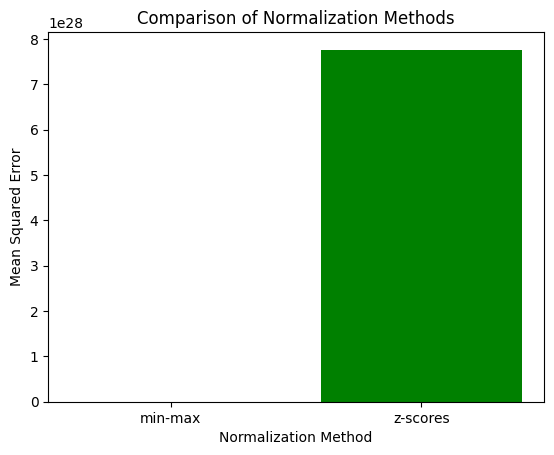

In [ ]:
# Extract features and Output
X = housing_df.drop(columns=['MEDV']).values
y = housing_df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

def compare_normalization(normalizations):
  losses = []
  for normalization in normalizations:
    if normalization == "min-max":
      X_train_normalized = pd.DataFrame(X_train).apply(min_max_normalize_column).values
      X_test_normalized = pd.DataFrame(X_test).apply(min_max_normalize_column).values
      print("MSE using min-max:")
    elif normalization == "z-scores":
      X_train_normalized = pd.DataFrame(X_train).apply(z_score_normalize_column).values
      X_test_normalized = pd.DataFrame(X_test).apply(z_score_normalize_column).values
      print("MSE using z-scores:")
    gradientDescent = GradientDescent(learning_rate=0.5, max_iters=50, epsilon=1e-8)
    model = LinearRegression()
    model.fit(X_train_normalized, y_train, gradientDescent)
    y_pred = model.predict(X_test_normalized)
    loss = model.cal_mean_square_error(y_pred=y_pred, y_test=y_test)
    losses.append(loss)
    print(loss)

  # Create a bar plot to compare losses for different normalization methods
  plt.bar(normalizations, losses, color=['blue', 'green'])
  plt.xlabel('Normalization Method')
  plt.ylabel('Mean Squared Error')
  plt.title('Comparison of Normalization Methods')
  plt.show()

gradientDescent = GradientDescent(learning_rate=0.5, max_iters=50, epsilon=1e-8)
compare_normalization(["min-max", "z-scores"])

#### 2. Experiment in Learning Rates


*   Testing in 6 different learning rates
*   Compare the loss history, assume that the iterations are 500
*   The 0.5 learning rate plays the best



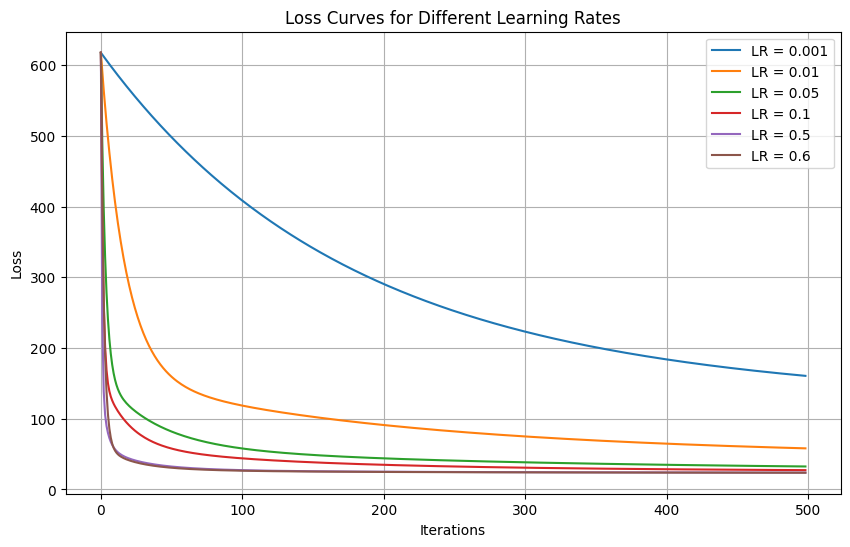

In [ ]:
# Define the learning rates to test
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5, 0.6]

# Initialize lists to store loss histories for each learning rate
loss_histories = []

# Loop through each learning rate and train the model
for lr in learning_rates:
    gradientDescent = GradientDescent(learning_rate=lr, max_iters=500, epsilon=1e-8)
    model = LinearRegression()
    model.fit(X_train_normalized, y_train, gradientDescent)
    loss_histories.append(gradientDescent.loss_history)

# Create a figure and plot the loss curves for each learning rate
plt.figure(figsize=(10, 6))
for i, lr in enumerate(learning_rates):
    plt.plot(range(len(loss_histories[i])), loss_histories[i], label=f'LR = {lr}')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curves for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()


#### 3. Experiment in Iterations


*   Testing in 10 different iterations
*   Compare the loss history, assume that the learning rate is 0.5
*   The 1000 iterations is best, using relatively fast training time and better final performance

Iterations = 100:
Training Time: 0.011817693710327148 seconds
Final MSE: 27.268885852459746

Iterations = 200:
Training Time: 0.012693643569946289 seconds
Final MSE: 25.039737546928013

Iterations = 300:
Training Time: 0.02794361114501953 seconds
Final MSE: 24.348282229121132

Iterations = 400:
Training Time: 0.03146648406982422 seconds
Final MSE: 23.97092445952534

Iterations = 500:
Training Time: 0.030874013900756836 seconds
Final MSE: 23.743645329652303

Iterations = 600:
Training Time: 0.03885245323181152 seconds
Final MSE: 23.604038590106352

Iterations = 700:
Training Time: 0.07381439208984375 seconds
Final MSE: 23.517612897666137

Iterations = 800:
Training Time: 0.06346821784973145 seconds
Final MSE: 23.46384535388236

Iterations = 900:
Training Time: 0.057053327560424805 seconds
Final MSE: 23.43027450253682

Iterations = 1000:
Training Time: 0.06271791458129883 seconds
Final MSE: 23.40925618428979

Iterations = 1100:
Training Time: 0.07460355758666992 seconds
Final MSE: 23.396

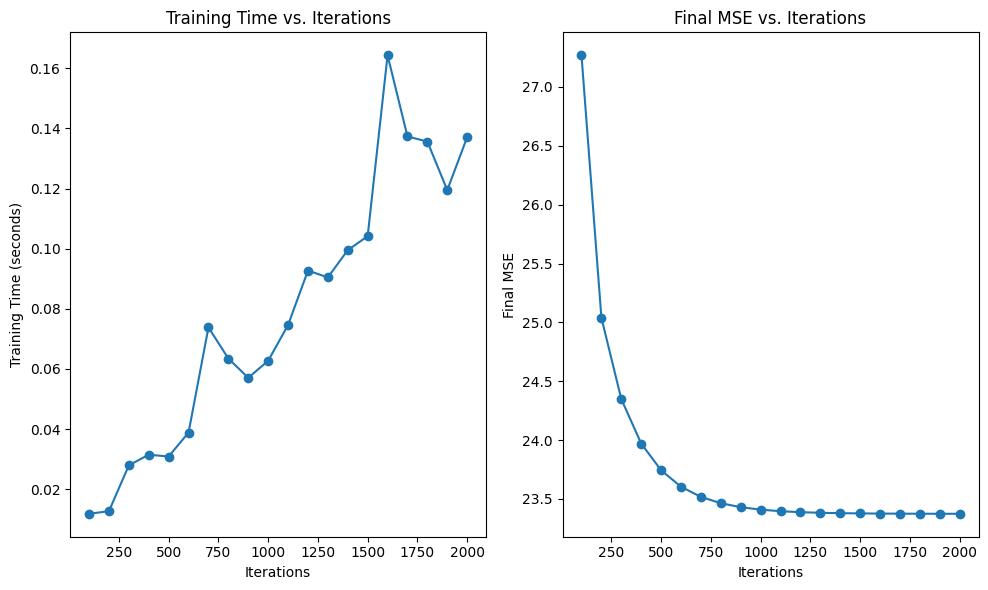

In [ ]:
import time

# Set the learning rate to 0.5 (since you found it to be the best fit)
learning_rate = 0.5

# Define the number of iterations to test
iterations_to_test = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]

# Initialize lists to store training times and final MSE values
training_times = []
final_mse_values = []

# Loop through each number of iterations and train the model
for num_iterations in iterations_to_test:
    start_time = time.time()
    gradientDescent = GradientDescent(learning_rate=learning_rate, max_iters=num_iterations, epsilon=1e-8)
    model = LinearRegression()
    model.fit(X_train_normalized, y_train, gradientDescent)
    end_time = time.time()

    # Record training time
    training_time = end_time - start_time
    training_times.append(training_time)

    # Compute final MSE on the training set
    y_pred = model.predict(X_train_normalized)
    final_mse = model.cal_mean_square_error(y_train, y_pred)
    final_mse_values.append(final_mse)

# Print and compare training times and final MSE values
for i, num_iterations in enumerate(iterations_to_test):
    print(f"Iterations = {num_iterations}:")
    print(f"Training Time: {training_times[i]} seconds")
    print(f"Final MSE: {final_mse_values[i]}\n")

# Optionally, you can plot the training times and final MSE values for comparison
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(iterations_to_test, training_times, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs. Iterations')

plt.subplot(1, 2, 2)
plt.plot(iterations_to_test, final_mse_values, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Final MSE')
plt.title('Final MSE vs. Iterations')

plt.tight_layout()
plt.show()


#### 4. The Best Parameters Configuration


* Normalization - Min-Max
* Learning Rate - 0.5
* Iterations - 1000

In [ ]:
# Normalization - Min-Max
# Learning Rate - 0.5
# Iterations - 1000

X_train_normalized = pd.DataFrame(X_train).apply(min_max_normalize_column).values
X_test_normalized = pd.DataFrame(X_test).apply(min_max_normalize_column).values

gradientDescent = GradientDescent(learning_rate=0.5, max_iters=1000, epsilon=1e-8)
model = LinearRegression()
model.fit(X_train_normalized, y_train, gradientDescent)
y_pred = model.predict(X_test_normalized)
mse = model.cal_mean_square_error(y_pred=y_pred, y_test=y_test)

print(f"The relatively best MSE using gradient descent is {mse}")
print("Normalization - Min-Max")
print("Learning Rate - 0.5")
print("Iterations - 1000")

The relatively best MSE using gradient descent is 22.19871526683131
Normalization - Min-Max
Learning Rate - 0.5
Iterations - 1000


### A1.2 Using Mini-batch SGD:

##### i. Optimizer for Mini SGD

In [ ]:
class MiniBatchGradientDescent:
    def __init__(self, learning_rate=0.01, max_iters=500, batch_size=30):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.batch_size = batch_size
        self.w_history = []
        self.loss_history = []

    def run(self, X, Y, w):
        t = 1
        N = X.shape[0]
        indices = np.arange(N)
        np.random.shuffle(indices)  # Shuffle the data
        X_shuffled = X[indices]
        Y_shuffled = Y[indices]

        while t <= self.max_iters:
            self.w_history.append(w)
            self.loss_history.append(cal_mse(X, Y, w))

            for i in range(0, N, self.batch_size):
                X_mini_batch = X_shuffled[i:i + self.batch_size]
                Y_mini_batch = Y_shuffled[i:i + self.batch_size]

                grad = cal_L2_gradient(X_mini_batch, Y_mini_batch, w)
                w = w - self.learning_rate * grad

            t += 1
        return w

##### ii. Help Function (K-fold)

In [ ]:
def find_k_fold_cross_validation_mse(X, y, k, learning_rate, batch_size, iterations_to_test):
  avg_cross_val_mse = 0
  # Perform k-fold cross-validation
  fold_size = len(X) // k
  for fold in range(k):
      val_start = fold * fold_size
      val_end = (fold + 1) * fold_size
      X_val_fold = X[val_start:val_end]
      y_val_fold = y[val_start:val_end]

      X_train_fold = np.vstack([X[:val_start], X[val_end:]])
      y_train_fold = np.concatenate([y[:val_start], y[val_end:]])

      gradientDescent = MiniBatchGradientDescent(learning_rate=learning_rate, max_iters=num_iterations, batch_size=batch_size)
      model = LinearRegression()
      model.fit(X_train_fold, y_train_fold, gradientDescent)

      # Predict on the validation fold
      y_pred_val = model.predict(X_val_fold)

      # Calculate accuracy for this fold
      fold_mse = model.cal_mean_square_error(y_val_fold, y_pred_val)

      # Accumulate accuracy for averaging
      avg_cross_val_mse += fold_mse

  return avg_cross_val_mse


def k_fold_cross_validation_test_iterations(X, y, k, learning_rate, batch_size, iterations_to_test):
    # Initialize a list to store cross-validation accuracies
    cross_val_accuracies = []

    # Define the number of folds for cross-validation
    num_folds = k

    for num_iterations in iterations_to_test:
        start_time = time.time()
        avg_cross_val_mse = find_k_fold_cross_validation_mse(X, y, k, learning_rate, batch_size, num_iterations)
        end_time = time.time()

        # Calculate the average cross-validation accuracy
        avg_cross_val_mse /= num_folds

        # Record average cross-validation accuracy
        cross_val_accuracies.append(avg_cross_val_mse)

        print(f"Iterations = {num_iterations}:")
        print(f"Average Cross-Validation MSE: {avg_cross_val_mse}")
        print(f"Time Taken: {end_time - start_time} seconds\n")

    return cross_val_accuracies


def k_fold_cross_validation_test_batch_sizes(X, y, k, learning_rate, batch_sizes, iterations_to_test):
    # Initialize a list to store cross-validation accuracies
    cross_val_accuracies = []

    # Define the number of folds for cross-validation
    num_folds = k

    for batch_size in batch_sizes:
        start_time = time.time()
        avg_cross_val_mse = find_k_fold_cross_validation_mse(X, y, k, learning_rate, batch_size, num_iterations)
        end_time = time.time()

        # Calculate the average cross-validation accuracy
        avg_cross_val_mse /= num_folds

        # Record average cross-validation accuracy
        cross_val_accuracies.append(avg_cross_val_mse)

        print(f"Batch Size = {batch_size}:")
        print(f"Average Cross-Validation MSE: {avg_cross_val_mse}")
        print(f"Time Taken: {end_time - start_time} seconds\n")

    return cross_val_accuracies

### A1.2 Model Experiment
- Experiment with different minibatch sizes and compare their speed and final performance.
- Plot loss graphs for three different learning rates.
- Determine the best parameter configurations and provide an explanation.
- Compare the differences between analytical and SGD approaches, including training time and final results.

#### 1. Experiment in Different Learning Rate


*   Testing in 8 different learning rates
*   Compare the loss history, assume that the iterations are 500 and batch size is 30
*   As it is mini-batch SGD, it consists randomness and inconsistency each other. We decide to run each learning rate for 10 times to take the average to find out which LR is the best
*   The learning rate 0.3 is relatively the best in several trials



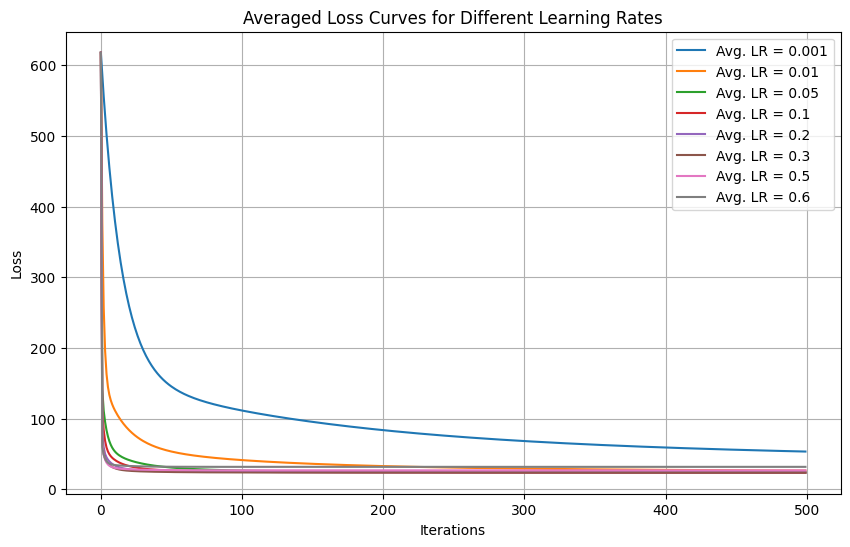

The best learning rate is: 0.3


In [ ]:
# Define the rates to test
X_train_normalized = pd.DataFrame(X_train).apply(min_max_normalize_column).values
X_test_normalized = pd.DataFrame(X_test).apply(min_max_normalize_column).values

learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.6]
batch_size = 30
iter = 500

# Define the number of trials for each learning rate
num_trials = 10

# Initialize lists to store average loss for each learning rate
average_losses = []

# Loop through each learning rate and perform trials
for lr in learning_rates:
    avg_loss = np.zeros(iter)
    for _ in range(num_trials):
        gradientDescent = MiniBatchGradientDescent(learning_rate=lr, max_iters=iter, batch_size=batch_size)
        model = LinearRegression()
        model.fit(X_train_normalized, y_train, gradientDescent)
        avg_loss += np.array(gradientDescent.loss_history) / num_trials  # Average loss over trials
    average_losses.append(np.mean(avg_loss))  # Store the average loss for this learning rate

# Find the learning rate with the lowest average loss
best_learning_rate = learning_rates[np.argmin(average_losses)]

# Create a figure and plot the averaged loss curves for each learning rate
plt.figure(figsize=(10, 6))
for i, lr in enumerate(learning_rates):
    plt.plot(range(len(loss_histories[i])), loss_histories[i], label=f'Avg. LR = {lr}')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Averaged Loss Curves for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

print(f"The best learning rate is: {best_learning_rate}")


#### 2. Experiment in Different Iterations


*   Testing in 20 different iterations
*   Because the mini-batch consists of much randomness, we test it in two ways to find the best iteration
*   First, we run 10 times for each iteration to take the average to find out the relationship between training time and MSE
*   Secondly, to be more accurate, we use 5-fold cross-validation to verify the parameter again
*   We choose the close parameter between the two approach. Finally, we found the iteration from 1200-1600 get the best result, with the learning rate 0.3



Iterations = 100:
Average Training Time: 0.019647383689880372 seconds
Average Final MSE: 24.952855217977017

Iterations = 200:
Average Training Time: 0.03787009716033936 seconds
Average Final MSE: 24.25505289797953

Iterations = 300:
Average Training Time: 0.05282196998596191 seconds
Average Final MSE: 24.120989198468443

Iterations = 400:
Average Training Time: 0.07218344211578369 seconds
Average Final MSE: 24.005847716625347

Iterations = 500:
Average Training Time: 0.11776721477508545 seconds
Average Final MSE: 24.318206936203875

Iterations = 600:
Average Training Time: 0.10941891670227051 seconds
Average Final MSE: 25.477162376221454

Iterations = 700:
Average Training Time: 0.23801569938659667 seconds
Average Final MSE: 24.146556684339693

Iterations = 800:
Average Training Time: 0.2665029287338257 seconds
Average Final MSE: 23.884770492068363

Iterations = 900:
Average Training Time: 0.1699329137802124 seconds
Average Final MSE: 23.955553340240222

Iterations = 1000:
Average Tra

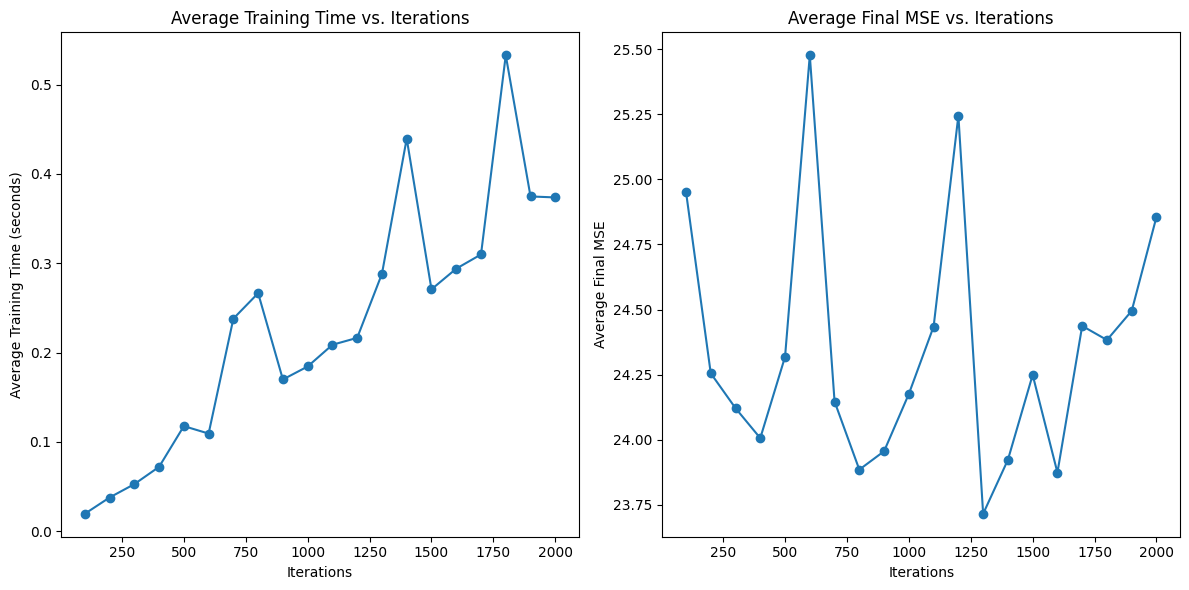

In [ ]:
import time

# Set the learning rate to 0.3 (since we found it to be the best fit)
learning_rate = 0.3

# Set the batch size to 30
batch_size = 30

# Define the number of iterations to test
iterations_to_test = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]

# Define the number of trials for each iteration
num_trials = 10

# Initialize lists to store training times and final MSE values
training_times = []
final_mse_values = []

# Loop through each number of iterations and run multiple trials
for num_iterations in iterations_to_test:
    avg_training_time = 0
    avg_final_mse = 0
    for _ in range(num_trials):
        start_time = time.time()
        gradientDescent = MiniBatchGradientDescent(learning_rate=learning_rate, max_iters=num_iterations, batch_size=batch_size)
        model = LinearRegression()
        model.fit(X_train_normalized, y_train, gradientDescent)
        end_time = time.time()

        # Calculate training time for this trial
        training_time = end_time - start_time
        avg_training_time += training_time

        # Compute final MSE on the training set for this trial
        y_pred = model.predict(X_train_normalized)
        final_mse = model.cal_mean_square_error(y_train, y_pred)
        avg_final_mse += final_mse

    # Calculate average training time and average final MSE over trials
    avg_training_time /= num_trials
    avg_final_mse /= num_trials

    # Record average training time and average final MSE
    training_times.append(avg_training_time)
    final_mse_values.append(avg_final_mse)

# Find the index of the iteration with the lowest average final MSE
best_iteration_index = np.argmin(final_mse_values)
best_iteration = iterations_to_test[best_iteration_index]
best_avg_final_mse = final_mse_values[best_iteration_index]

# Print and compare average training times and average final MSE values
for i, num_iterations in enumerate(iterations_to_test):
    print(f"Iterations = {num_iterations}:")
    print(f"Average Training Time: {training_times[i]} seconds")
    print(f"Average Final MSE: {final_mse_values[i]}\n")

# Display the best iteration
print(f"The best iteration is {best_iteration} with an average final MSE of {best_avg_final_mse}")

# Optionally, you can plot the average training times and average final MSE values for comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(iterations_to_test, training_times, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Average Training Time (seconds)')
plt.title('Average Training Time vs. Iterations')

plt.subplot(1, 2, 2)
plt.plot(iterations_to_test, final_mse_values, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Average Final MSE')
plt.title('Average Final MSE vs. Iterations')

plt.tight_layout()
plt.show()


Iterations = 100:
Average Cross-Validation MSE: 28.354816585429507
Time Taken: 2.749534845352173 seconds

Iterations = 200:
Average Cross-Validation MSE: 27.378089265920163
Time Taken: 2.6773993968963623 seconds

Iterations = 300:
Average Cross-Validation MSE: 28.04795792136173
Time Taken: 1.4904699325561523 seconds

Iterations = 400:
Average Cross-Validation MSE: 27.356020755739916
Time Taken: 1.5236458778381348 seconds

Iterations = 500:
Average Cross-Validation MSE: 29.57322186637195
Time Taken: 1.6414620876312256 seconds

Iterations = 600:
Average Cross-Validation MSE: 27.735425367194818
Time Taken: 1.541372537612915 seconds

Iterations = 700:
Average Cross-Validation MSE: 27.621458661405335
Time Taken: 1.5808289051055908 seconds

Iterations = 800:
Average Cross-Validation MSE: 27.975982340684006
Time Taken: 1.5529961585998535 seconds

Iterations = 900:
Average Cross-Validation MSE: 27.562488620555154
Time Taken: 2.443666934967041 seconds

Iterations = 1000:
Average Cross-Validatio

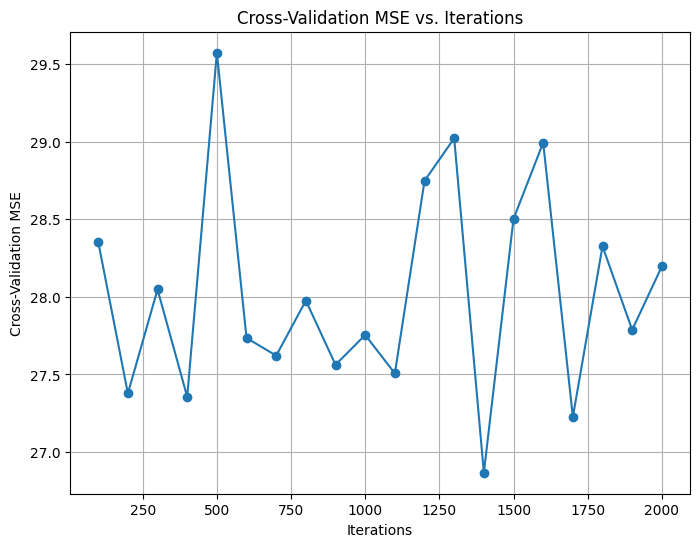

In [ ]:
k_fold = 5

def plot_iteration_differences(iterations, accuracies):
    plt.figure(figsize=(8, 6))
    plt.plot(iterations, accuracies, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Cross-Validation MSE')
    plt.title('Cross-Validation MSE vs. Iterations')
    plt.grid(True)
    plt.show()


cross_val_accuracies = k_fold_cross_validation_test_iterations(X_train_normalized, y_train, k=k_fold, learning_rate=learning_rate, batch_size=batch_size, iterations_to_test=iterations_to_test)
plot_iteration_differences(iterations_to_test, cross_val_accuracies)


#### 3. Experiment in Different Batch Size


*   Testing in 7 different batch sizes to find out which is the best
*   Assume the best learning rate is 0.3 and iteration is 1300 according to the previous experiment
*   We have compare the batch performance in MSE, time comsumption, and 5-fold cross-validation MSE

*   Finally, we find batch size between 30-40 perform better





Batch Size = 1:
Average Training Time: 5.127612686157226 seconds
Average Final MSE: 48.29683036121015

Batch Size = 10:
Average Training Time: 0.5623861074447631 seconds
Average Final MSE: 24.83343391859571

Batch Size = 20:
Average Training Time: 0.4821158409118652 seconds
Average Final MSE: 24.459108804966018

Batch Size = 30:
Average Training Time: 0.31280686855316164 seconds
Average Final MSE: 22.417618183008067

Batch Size = 40:
Average Training Time: 0.19997382164001465 seconds
Average Final MSE: 22.216571810333047

Batch Size = 50:
Average Training Time: 0.18566250801086426 seconds
Average Final MSE: 31.49065973191826

Batch Size = 152:
Average Training Time: 0.11781480312347412 seconds
Average Final MSE: 22.804923914175312



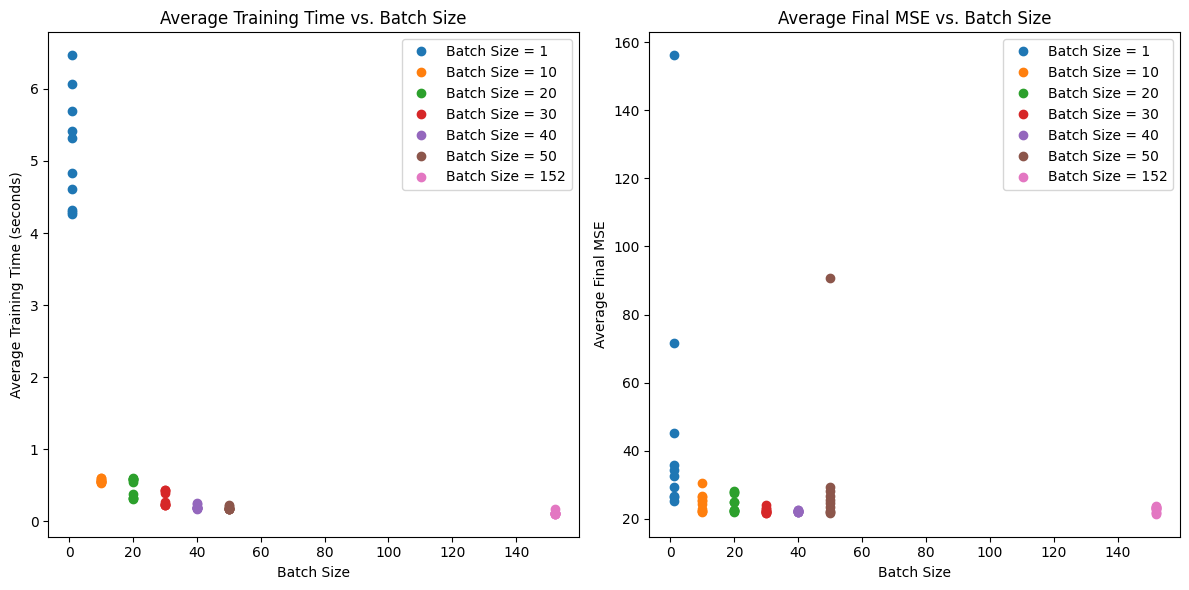

In [ ]:
import time

# Set the learning rate to 0.3
learning_rate = 0.3

# Define the batch sizes to test
batch_sizes_to_test = [1, 10, 20, 30, 40, 50, len(X_test_normalized)]

# Define the number of iterations for each batch size
num_iterations = 1300

# Define the number of trials for each batch size and iteration
num_trials = 10

# Initialize lists to store training times and final MSE values for each batch size
batch_size_results = {}

# Loop through each batch size and run experiments
for batch_size in batch_sizes_to_test:
    training_times = []
    final_mse_values = []

    for _ in range(num_trials):
        start_time = time.time()
        gradientDescent = MiniBatchGradientDescent(learning_rate=learning_rate, max_iters=num_iterations, batch_size=batch_size)
        model = LinearRegression()
        model.fit(X_train_normalized, y_train, gradientDescent)
        end_time = time.time()

        # Calculate training time for this trial
        training_time = end_time - start_time
        training_times.append(training_time)

        # Compute final MSE on the training set for this trial
        y_pred = model.predict(X_test_normalized)
        final_mse = model.cal_mean_square_error(y_test, y_pred)
        final_mse_values.append(final_mse)

    # Store the results for this batch size
    batch_size_results[batch_size] = {
        'training_times': training_times,
        'final_mse_values': final_mse_values
    }

# Print and compare average training times and average final MSE values for each batch size
for batch_size, results in batch_size_results.items():
    avg_training_time = np.mean(results['training_times'])
    avg_final_mse = np.mean(results['final_mse_values'])

    print(f"Batch Size = {batch_size}:")
    print(f"Average Training Time: {avg_training_time} seconds")
    print(f"Average Final MSE: {avg_final_mse}\n")

# Optionally, you can plot the average training times and average final MSE values for comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for batch_size, results in batch_size_results.items():
    plt.plot([batch_size] * num_trials, results['training_times'], 'o', label=f'Batch Size = {batch_size}')
plt.xlabel('Batch Size')
plt.ylabel('Average Training Time (seconds)')
plt.title('Average Training Time vs. Batch Size')
plt.legend()

plt.subplot(1, 2, 2)
for batch_size, results in batch_size_results.items():
    plt.plot([batch_size] * num_trials, results['final_mse_values'], 'o', label=f'Batch Size = {batch_size}')
plt.xlabel('Batch Size')
plt.ylabel('Average Final MSE')
plt.title('Average Final MSE vs. Batch Size')
plt.legend()

plt.tight_layout()
plt.show()


Batch Size = 1:
Average Cross-Validation MSE: 181.9156716151872
Time Taken: 19.400916576385498 seconds

Batch Size = 10:
Average Cross-Validation MSE: 31.478753361926483
Time Taken: 3.1378519535064697 seconds

Batch Size = 20:
Average Cross-Validation MSE: 28.670941700114213
Time Taken: 2.420619010925293 seconds

Batch Size = 30:
Average Cross-Validation MSE: 27.425511377677292
Time Taken: 1.3338582515716553 seconds

Batch Size = 40:
Average Cross-Validation MSE: 28.607468022698914
Time Taken: 0.9140148162841797 seconds

Batch Size = 50:
Average Cross-Validation MSE: 28.1027849021983
Time Taken: 0.7681095600128174 seconds

Batch Size = 152:
Average Cross-Validation MSE: 26.63490620383189
Time Taken: 0.4781928062438965 seconds



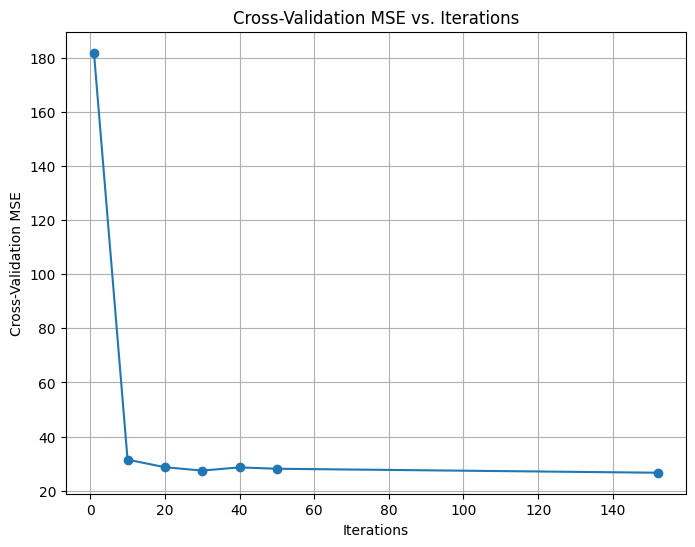

In [ ]:
k_fold = 5

def plot_batch_sizes_differences(batch_sizes, accuracies):
    plt.figure(figsize=(8, 6))
    plt.plot(batch_sizes, accuracies, marker='o')
    plt.xlabel('Batch Sizes')
    plt.ylabel('Cross-Validation MSE')
    plt.title('Cross-Validation MSE vs. Batch Sizes')
    plt.grid(True)
    plt.show()


cross_val_accuracies = k_fold_cross_validation_test_batch_sizes(X_train_normalized, y_train, k=k_fold, learning_rate=learning_rate, batch_sizes=batch_sizes_to_test, iterations_to_test=iterations_to_test)
plot_iteration_differences(batch_sizes_to_test, cross_val_accuracies)


#### 4. The Best Parameter Configurations


1.   The Normalization - Using Min-Max
2.   The learning rates - 0.3
3.   The iterations - 1300
4.   The batch size - 30



In [ ]:
# number of trial
no_trial = 30

# Best Parameters
learning_rate = 0.3
iterations = 1300
batch_size = 30

# output
training_time_mini = 0
mse_mini = 0
mae_mini = 0
r_square_mini = 0

for trial in range(no_trial):
  # training
  start_time = time.time()
  gradientDescent = MiniBatchGradientDescent(learning_rate=learning_rate, max_iters=iterations, batch_size=batch_size)
  model = LinearRegression()
  model.fit(X_train_normalized, y_train, gradientDescent)
  end_time = time.time()

  # prediction
  y_pred = model.predict(X_test_normalized)

  # create output
  training_time_mini += (end_time - start_time)
  mse_mini += model.cal_mean_square_error(y_pred = y_pred, y_test = y_test)
  mae_mini += model.cal_mean_absolute_error(y_pred = y_pred, y_test = y_test)
  r_square_mini += model.cal_r_squared(y_pred = y_pred, y_test = y_test)

# take the average
training_time_mini = training_time_mini/no_trial
mse_mini = mse_mini/no_trial
mae_mini = mae_mini/no_trial
r_square_mini = r_square_mini/no_trial


print(f"training_time: {training_time_mini}")
print(f"mse: {mse_mini}")
print(f"mae: {mae_mini}")
print(f"r_square: {r_square_mini}")


training_time: 0.2842901150385539
mse: 22.71976181276975
mae: 3.492555294614983
r_square: 0.6950903510366654


#### 5. Comparing Minibatch, SGD, and GD


*   Testing in 6 different learning rates
*   Compare the loss history, assume that the iterations are 500
*   The 0.5 learning rate plays the best

In [ ]:
X = housing_df.drop(columns=['MEDV']).values
y = housing_df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

Run the Analytical LR

In [ ]:
# output
training_time_ana = 0
mse_ana = 0
mae_ana = 0
r_square_ana = 0

# train
start_time = time.time()
model = LinearRegressionModel()
model.fit(X_train, y_train)
end_time = time.time()

# predict
y_pred = model.predict(X_test)

# save
training_time_ana += (end_time - start_time)
mse_ana += model.cal_mean_square_error(y_pred = y_pred, y_test = y_test)
mae_ana += model.cal_mean_absolute_error(y_pred = y_pred, y_test = y_test)
r_square_ana += model.cal_r_squared(y_pred = y_pred, y_test = y_test)

Run the GD

In [ ]:
# Best Parameters
learning_rate = 0.5
iterations = 1000

# output
training_time_gd = 0
mse_gd= 0
mae_gd = 0
r_square_gd = 0

# normalized
X_train_normalized = pd.DataFrame(X_train).apply(min_max_normalize_column).values
X_test_normalized = pd.DataFrame(X_test).apply(min_max_normalize_column).values

# train
start_time = time.time()
gradientDescent = GradientDescent(learning_rate=learning_rate, max_iters=iterations, epsilon=1e-8)
model = LinearRegression()
model.fit(X_train_normalized, y_train, gradientDescent)
end_time = time.time()

# predict
y_pred = model.predict(X_test_normalized)

# save
training_time_gd += (end_time - start_time)
mse_gd += model.cal_mean_square_error(y_pred = y_pred, y_test = y_test)
mae_gd += model.cal_mean_absolute_error(y_pred = y_pred, y_test = y_test)
r_square_gd += model.cal_r_squared(y_pred = y_pred, y_test = y_test)

##### A. Comparing Training Time


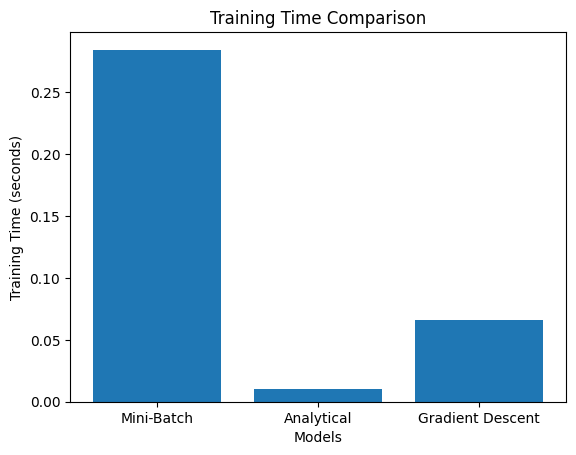

In [ ]:
def plot_training_time(training_time_mini, training_time_ana, training_time_gd):
    models = ['Mini-Batch', 'Analytical', 'Gradient Descent']
    times = [training_time_mini, training_time_ana, training_time_gd]

    plt.bar(models, times)
    plt.xlabel('Models')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison')
    plt.show()

plot_training_time(training_time_mini, training_time_ana, training_time_gd)


##### B. Comparing MSE


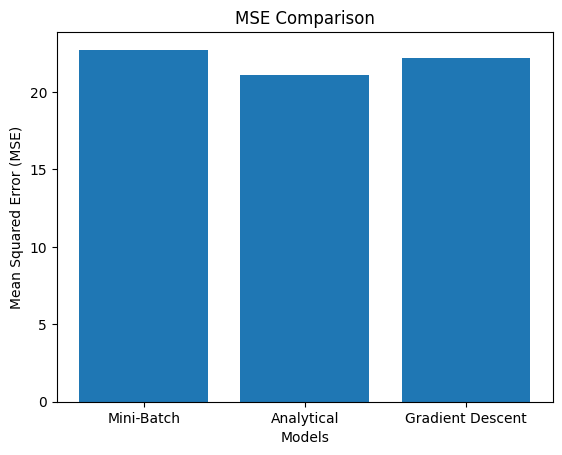

In [ ]:
def plot_mse(mse_mini, mse_ana, mse_gd):
    models = ['Mini-Batch', 'Analytical', 'Gradient Descent']
    mse_values = [mse_mini, mse_ana, mse_gd]

    plt.bar(models, mse_values)
    plt.xlabel('Models')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE Comparison')
    plt.show()

plot_mse(mse_mini, mse_ana, mse_gd)


##### C. Comparing MAE


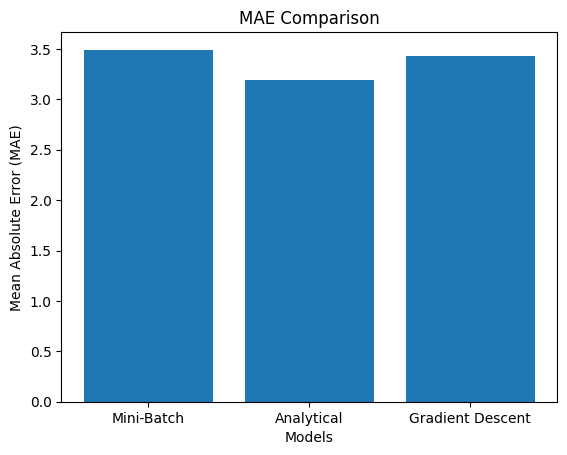

In [ ]:
def plot_mae(mae_mini, mae_ana, mae_gd):
    models = ['Mini-Batch', 'Analytical', 'Gradient Descent']
    mae_values = [mae_mini, mae_ana, mae_gd]

    plt.bar(models, mae_values)
    plt.xlabel('Models')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE Comparison')
    plt.show()

plot_mae(mae_mini, mae_ana, mae_gd)


##### D. Comparing R square


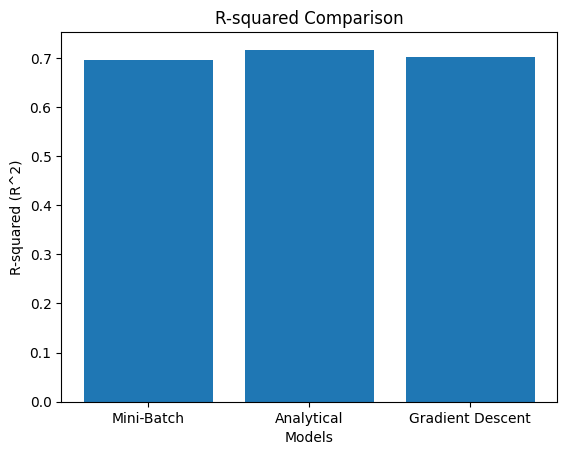

In [ ]:
def plot_r_squared(r_square_mini, r_square_ana, r_square_gd):
    models = ['Mini-Batch', 'Analytical', 'Gradient Descent']
    r_square_values = [r_square_mini, r_square_ana, r_square_gd]

    plt.bar(models, r_square_values)
    plt.xlabel('Models')
    plt.ylabel('R-squared (R^2)')
    plt.title('R-squared Comparison')
    plt.show()

plot_r_squared(r_square_mini, r_square_ana, r_square_gd)